In [1]:
import glob
import os
import pickle
import random
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import mdtraj as md
import numpy as np
# import pyemma
import scipy
import seaborn as sns
from matplotlib import ticker
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import NearestNeighbors

import extq
import prettypyplot as pplt

In [2]:
! source /project/dinner/scguo/upside2/sourceme.sh

In [3]:
# upside_path = os.environ["UPSIDE_HOME"]
upside_path = "/project/dinner/scguo/upside2/"
upside_utils_dir = os.path.expanduser(upside_path + "/py")
sys.path.insert(0, upside_utils_dir)
import mdtraj_upside as mu

In [4]:
plt.style.use("custom")  # custom style sheet
plt.style.use("muted")
pplt.load_cmaps()
pplt.load_colors()

In [5]:
plt.rcParams[
    "text.latex.preamble"
] = r"\usepackage{siunitx}\sisetup{detect-all}\usepackage{helvet}\usepackage{sansmath}\sansmath"
mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["font.sans-serif"] = "cm"

In [6]:
ss_colormap = {
    "H": "C0",
    "B": "C1",
    "E": "C2",
    "G": "C3",
    "I": "C4",
    "T": "C5",
    "S": "C6",
    " ": "C7",
}

In [7]:
def convert_to_array(dssp, simplified=True):
    ans = np.zeros_like(dssp, dtype=int)
    if simplified:
        ans[np.where(dssp == "H")] = 0
        ans[np.where(dssp == "E")] = 1
        ans[np.where(dssp == "C")] = 2
    else:
        ans[np.where(dssp == "H")] = 0
        ans[np.where(dssp == "B")] = 1
        ans[np.where(dssp == "E")] = 2
        ans[np.where(dssp == "G")] = 3
        ans[np.where(dssp == "I")] = 4
        ans[np.where(dssp == "T")] = 5
        ans[np.where(dssp == "S")] = 6
        ans[np.where(dssp == " ")] = 7
    return ans

In [8]:
labels = [
    r"$\alpha$-helix",
    r"$\beta$-bridge",
    r"$\beta$-strand",
    r"$3_{10}$-helix",
    r"$\pi$-helix",
    "turn",
    "bend",
    "loop",
]

In [9]:
simple_labels = [r"$\alpha$-helix", r"$\beta$-strand", "coil"]

In [33]:
def plot_dssp(dssp, rmsds_fs, rmsds_gs, rmsds_gs_core, s, e, i, skip1=20, skip2=10, transition=None, **legend_kwargs):
    fig, (ax0, ax1) = plt.subplots(nrows=2, figsize=(7, 3), dpi=500, sharex=True, constrained_layout=True)

    cmap = mpl.cm.get_cmap("paula", 3)
    if transition is not None:
        transition_start, transition_end = transition

    x = np.arange(s, e, skip1)
    y = np.arange(47, 95)
    im = ax0.pcolormesh(x, y, dssp[s:e:skip1, 46:].T, cmap=cmap, vmin=-0.5, vmax=2.5)
    if transition is not None:
        ax0.axvline(transition_start, color="w", ls="--", lw=1.0)
        ax0.axvline(transition_end, color="w", ls="--", lw=1.0)
    ax0.invert_yaxis()
    # ax0.set_xlabel("Time (A.U.)")
    ax0.set_ylabel("Residue number")
    # cb = pplt.colorbar(im, position="top", pad="5%", fraction=0.5)
    cb = plt.colorbar(im, ax=ax0, location="top", pad=0.05, shrink=0.5, aspect=40)
    cb.set_ticks(np.arange(3), labels=simple_labels, ha="center", rotation=0)
    cb.ax.tick_params(length=0)

    t = np.arange(s, e, skip2)
    ax1.plot(t, rmsds_fs[i][s:e:skip2] * 10, "C0", alpha=0.75, label="fs")
    ax1.plot(t, rmsds_gs[i][s:e:skip2] * 10, "C2", alpha=0.75, label="gs")
    ax1.plot(t, rmsds_gs_core[i][s:e:skip2] * 10, "C3", alpha=0.75, label="gs (core)")
    if transition is not None:
        ax1.axvline(transition_start, color="k", ls="--", lw=1.0)
        ax1.axvline(transition_end, color="k", ls="--", lw=1.0)
    ax1.set_xlabel("Time (A.U.)")
    ax1.set_ylabel("RMSD (Å)")
    ax1.set_xlim([s, e - 1])
    ax1.set_ylim([0, 15])
    ax1.label_outer()
    ax1.ticklabel_format(useOffset=False, style='plain')
    ax1.legend(title="RMSD to", frameon=True, **legend_kwargs)

    return fig, (ax0, ax1)

In [18]:
def plot_dssp(dssp, rmsds_fs, rmsds_gs, rmsds_gs_core, s, e, i, skip1=20, skip2=10, transition=None, **legend_kwargs):
    fig, (ax0, ax1) = plt.subplots(nrows=2, figsize=(7, 3), dpi=500, sharex=True, constrained_layout=True)

    cmap = mpl.cm.get_cmap("paula", 3)
    if transition is not None:
        transition_start, transition_end = transition

    x = np.arange(s, e, skip1)
    y = np.arange(1, 95)
    im = ax0.pcolormesh(x, y, dssp[s:e:skip1].T, cmap=cmap, vmin=-0.5, vmax=2.5)
    if transition is not None:
        ax0.axvline(transition_start, color="w", ls="--", lw=1.0)
        ax0.axvline(transition_end, color="w", ls="--", lw=1.0)
    ax0.invert_yaxis()
    # ax0.set_xlabel("Time (A.U.)")
    ax0.set_ylabel("Residue number")
    cb = plt.colorbar(im, ax=ax0, location="top", pad=0.05, shrink=0.5, aspect=40)
    cb.set_ticks(np.arange(3), labels=simple_labels, ha="center", rotation=0)
    cb.ax.tick_params(length=0)

    t = np.arange(s, e, skip2)
    ax1.plot(t, rmsds_fs[i][s:e:skip2] * 10, "C0", alpha=0.75, label="fs")
    ax1.plot(t, rmsds_gs[i][s:e:skip2] * 10, "C2", alpha=0.75, label="gs")
    ax1.plot(t, rmsds_gs_core[i][s:e:skip2] * 10, "C3", alpha=0.75, label="gs (core)")
    if transition is not None:
        ax1.axvline(transition_start, color="k", ls="--", lw=1.0)
        ax1.axvline(transition_end, color="k", ls="--", lw=1.0)
    ax1.set_xlabel("Time (A.U.)")
    ax1.set_ylabel("RMSD (Å)")
    ax1.set_xlim([s, e - 1])
    ax1.set_ylim([0, 15])
    ax1.label_outer()
    ax1.ticklabel_format(useOffset=False, style='plain')
    ax1.legend(title="RMSD to", frameon=True, **legend_kwargs)

    return fig, (ax0, ax1)

# fs-> gs run_0, run#13

In [11]:
rmsds_fs = np.load(
    "/project/dinner/scguo/kaiB/fixed_p_runs/trans_fs/outputs/trans_fs_f_rmsds.pkl", allow_pickle=True
)
rmsds_gs = np.load(
    "/project/dinner/scguo/kaiB/fixed_p_runs/trans_fs/outputs/trans_fs_p_rmsds.pkl", allow_pickle=True
)
rmsds_gs_core = np.load(
    "/project/dinner/scguo/kaiB/fixed_p_runs/trans_fs/outputs/trans_fs_r_rmsds.pkl", allow_pickle=True
)

In [12]:
traj = mu.load_upside_traj("/project/dinner/scguo/kaiB/fixed_p_runs/trans_fs/run_0/fs_d91r.run.13.up")

In [13]:
traj

<mdtraj.Trajectory with 39997 frames, 562 atoms, 94 residues, without unitcells at 0x7ff60d58b750>

## full DSSP assignment

In [14]:
dssp = md.compute_dssp(traj, simplified=False)

dssp = convert_to_array(dssp, simplified=False)

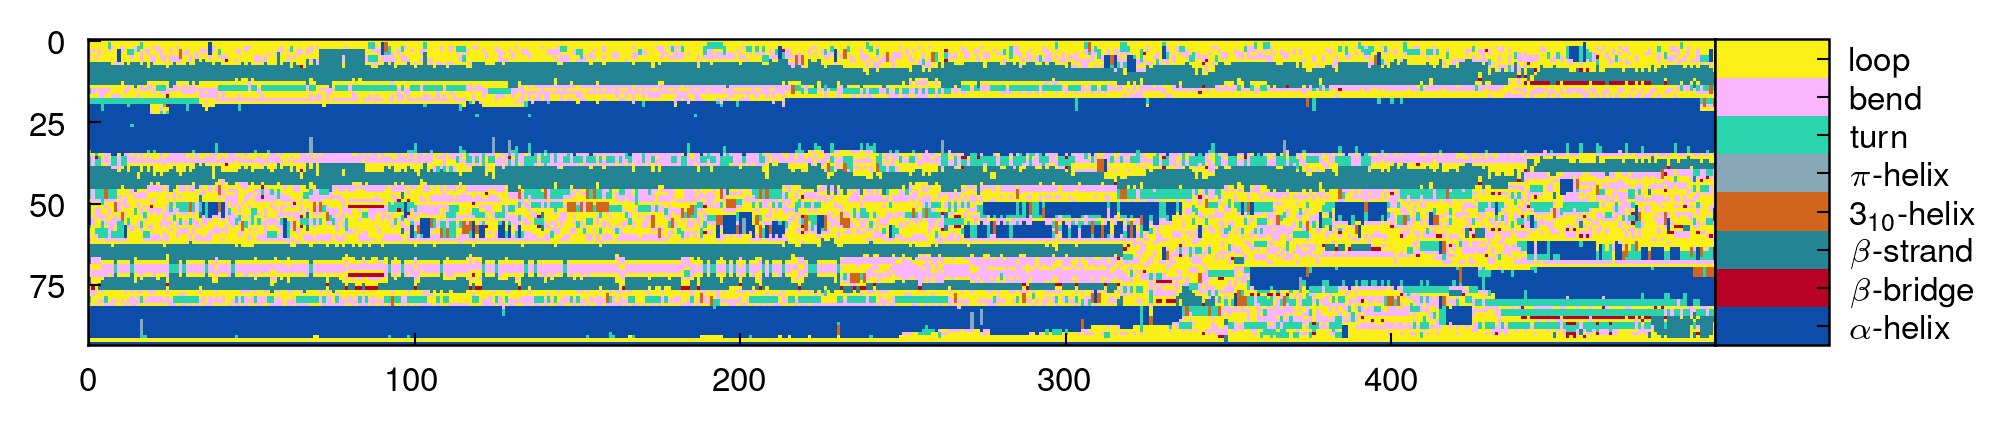

In [15]:
plt.figure(figsize=(7, 2), dpi=300)
s, e, skip = 0, 5000, 10
im = plt.imshow(dssp[s:e:skip, :].T, cmap="cbf8", vmin=-0.5, vmax=7.5)
cb = pplt.colorbar(im)
cb.set_ticks(np.arange(8), labels=labels)

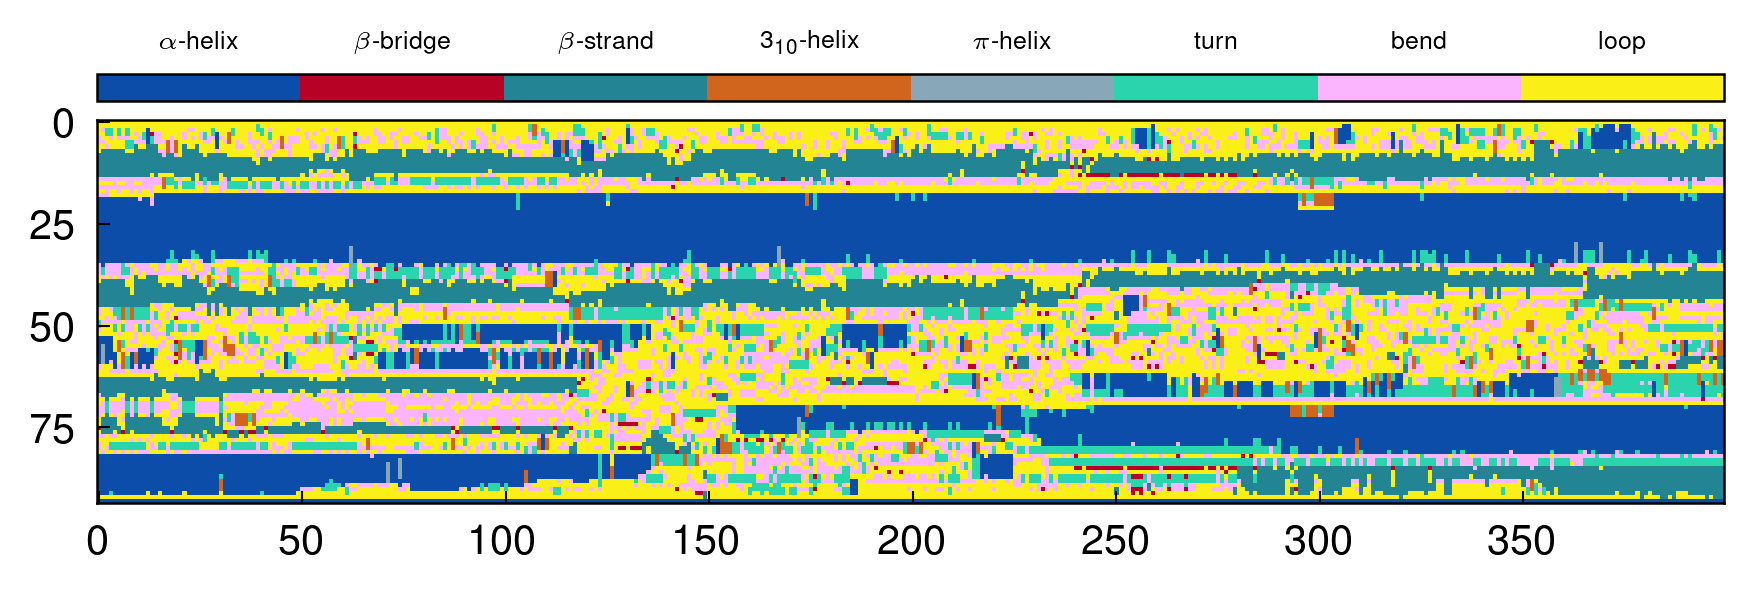

In [62]:
plt.figure(figsize=(7, 5), dpi=300)
s, e, skip = 2000, 6000, 10
im = plt.imshow(dssp[s:e:skip, :].T, cmap="cbf8", vmin=-0.5, vmax=7.5)
cb = pplt.colorbar(im, position="top", pad="5%")
cb.set_ticks(np.arange(8), labels=labels, ha="center", rotation=0, fontsize=6)
cb.ax.tick_params(length=0)

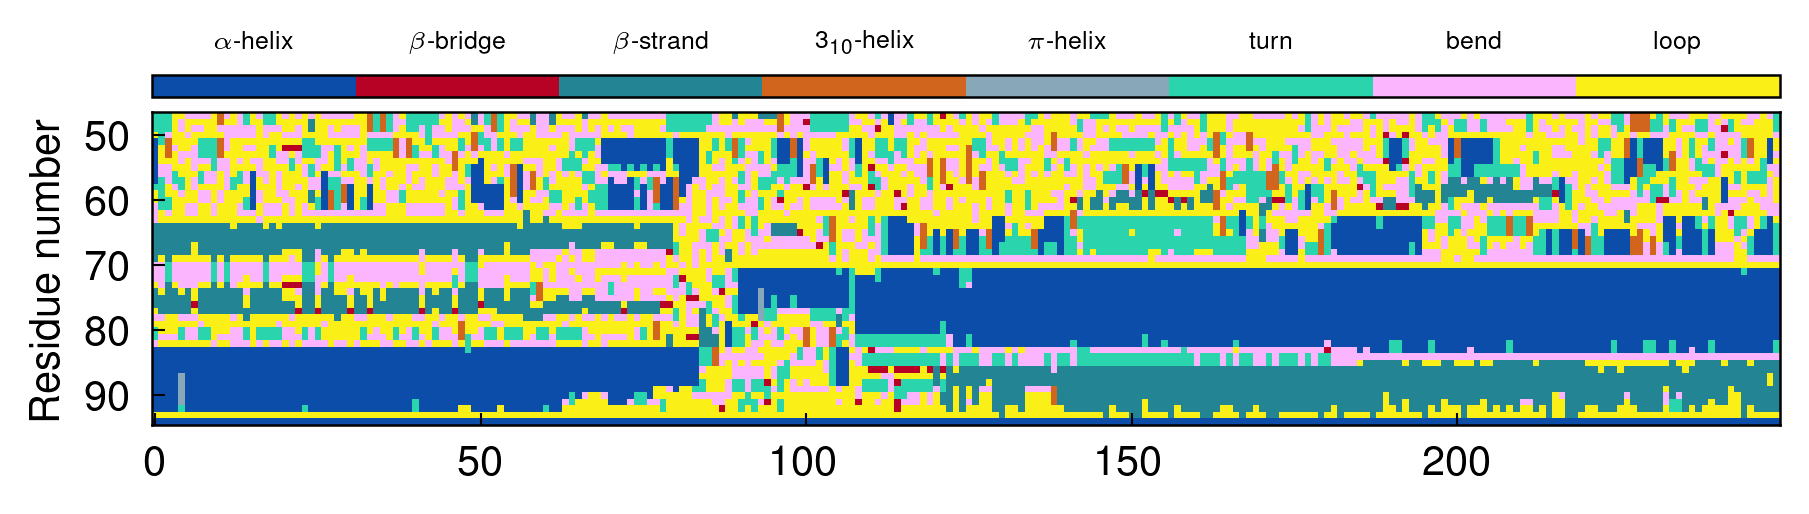

In [78]:
plt.figure(figsize=(7, 2), dpi=300)
s, e, skip = 0, 10000, 40
im = plt.imshow(dssp[s:e:skip, 46:].T, cmap="cbf8", vmin=-0.5, vmax=7.5, aspect="equal")
# plt.xticks(ticks=np.arange(s, e,
plt.yticks(ticks=np.arange(3, 51, 10), labels=np.arange(3, 51, 10) + 47)
plt.ylabel("Residue number")
cb = pplt.colorbar(im, position="top", pad="5%")
cb.set_ticks(np.arange(8), labels=labels, ha="center", rotation=0, fontsize=6)
cb.ax.tick_params(length=0)

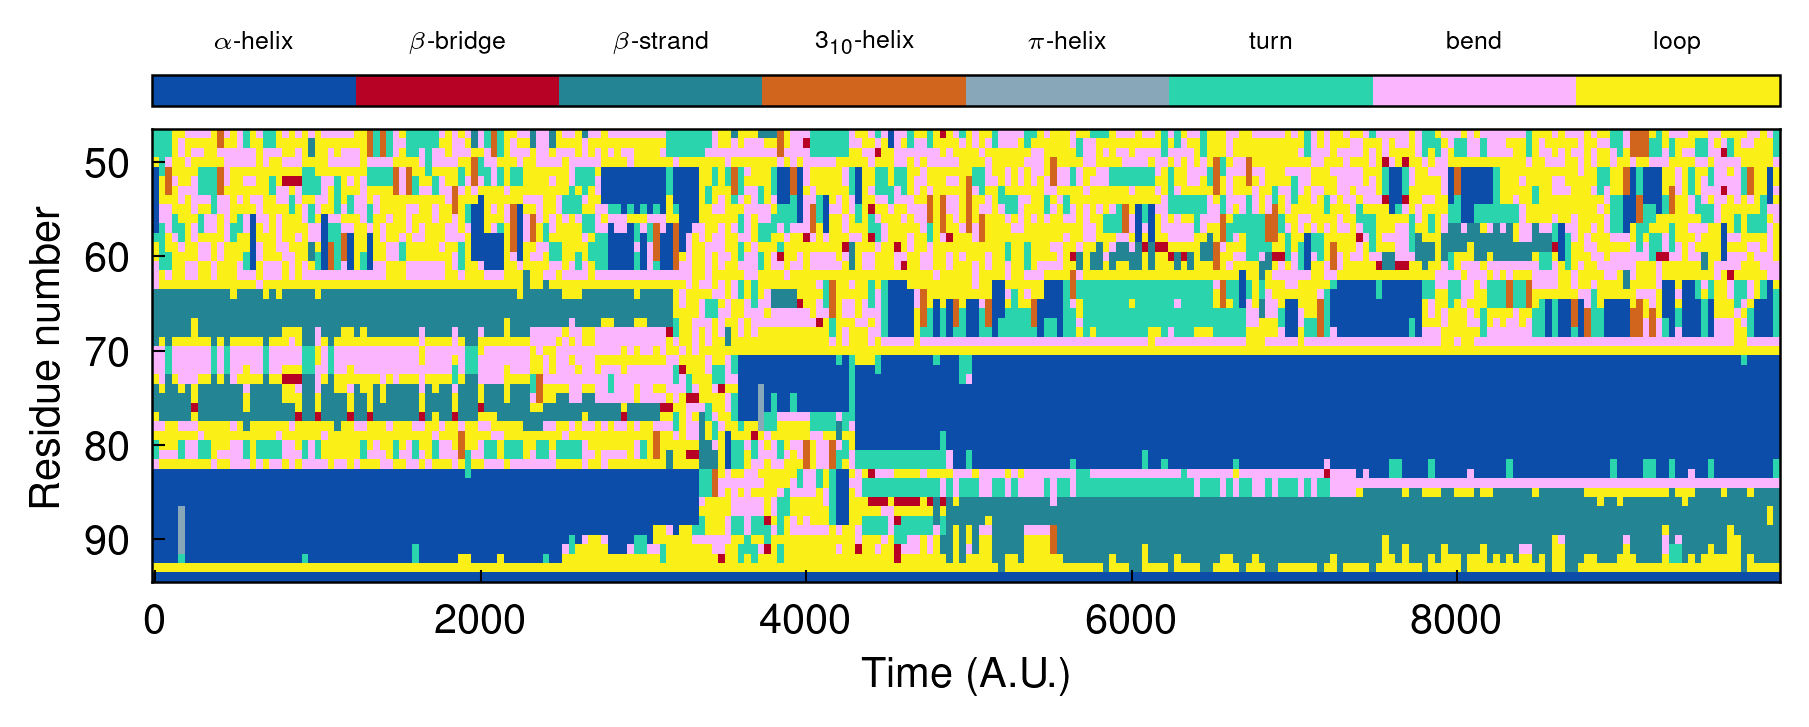

In [82]:
plt.figure(figsize=(7, 2), dpi=300)
ax = plt.gca()

s, e, skip = 0, 10000, 40
x = np.arange(s, e, skip)
y = np.arange(47, 95)
im = plt.pcolormesh(x, y, dssp[s:e:skip, 46:].T, cmap="cbf8", vmin=-0.5, vmax=7.5)
ax.invert_yaxis()
plt.xlabel("Time (A.U.)")
plt.ylabel("Residue number")
cb = pplt.colorbar(im, position="top", pad="5%")
cb.set_ticks(np.arange(8), labels=labels, ha="center", rotation=0, fontsize=6)
cb.ax.tick_params(length=0)

## Simplified DSSP assignment

In [16]:
dssp = md.compute_dssp(traj, simplified=True)
dssp = convert_to_array(dssp, simplified=True)

/scratch/local/jobs/10917107/ipykernel_442679/1274635292.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  mpl.cm.get_cmap("pastel_autunm", 3)


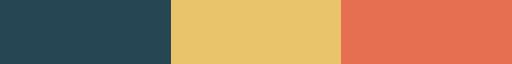

In [17]:
mpl.cm.get_cmap("pastel_autunm", 3)

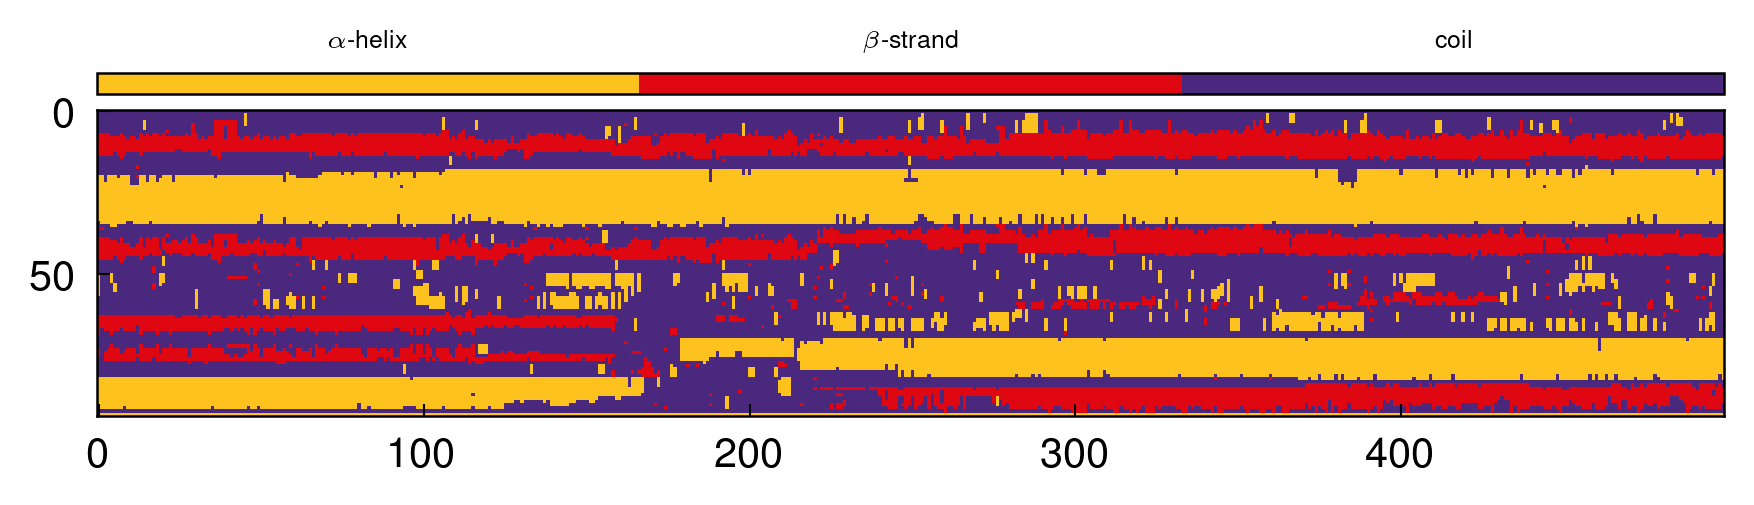

In [105]:
plt.figure(figsize=(7, 2), dpi=300)
s, e, skip = 0, 10000, 20
cmap = mpl.cm.get_cmap("paula", 3)
im = plt.imshow(dssp[s:e:skip, :].T, cmap=cmap, vmin=-0.5, vmax=2.5)

cb = pplt.colorbar(im, position="top", pad="5%")
cb.set_ticks(np.arange(3), labels=simple_labels, ha="center", rotation=0, fontsize=6)
cb.ax.tick_params(length=0)

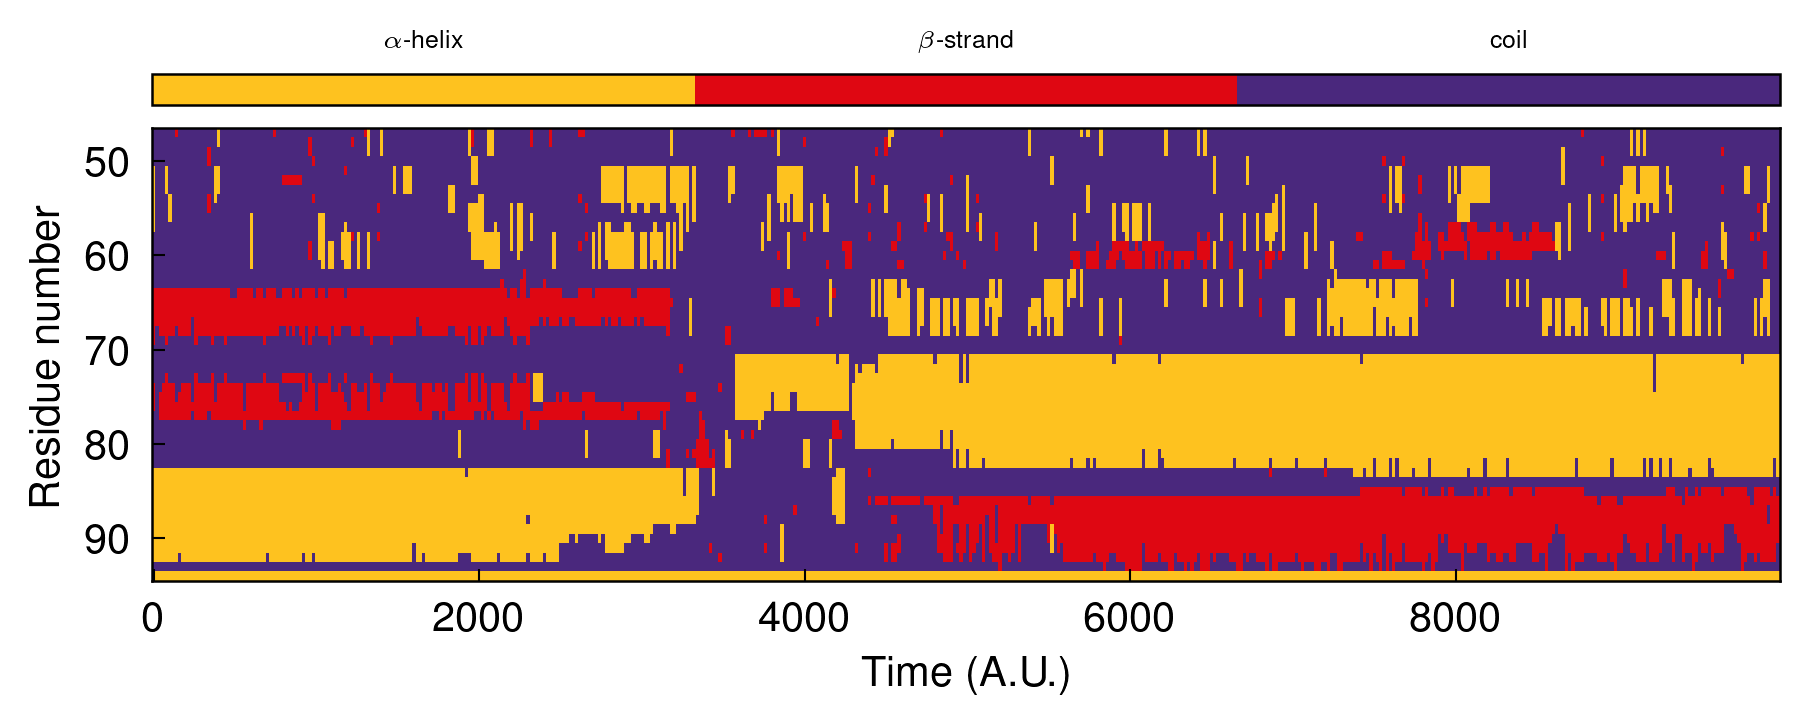

In [110]:
plt.figure(figsize=(7, 2), dpi=300)
ax = plt.gca()

cmap = mpl.cm.get_cmap("paula", 3)
s, e, skip = 0, 10000, 20
x = np.arange(s, e, skip)
y = np.arange(47, 95)
im = plt.pcolormesh(x, y, dssp[s:e:skip, 46:].T, cmap=cmap, vmin=-0.5, vmax=2.5)
ax.invert_yaxis()
plt.xlabel("Time (A.U.)")
plt.ylabel("Residue number")
cb = pplt.colorbar(im, position="top", pad="5%")
cb.set_ticks(np.arange(3), labels=simple_labels, ha="center", rotation=0, fontsize=6)
cb.ax.tick_params(length=0)

/scratch/local/jobs/9971634/ipykernel_2918447/2757810600.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap("paula", 3)


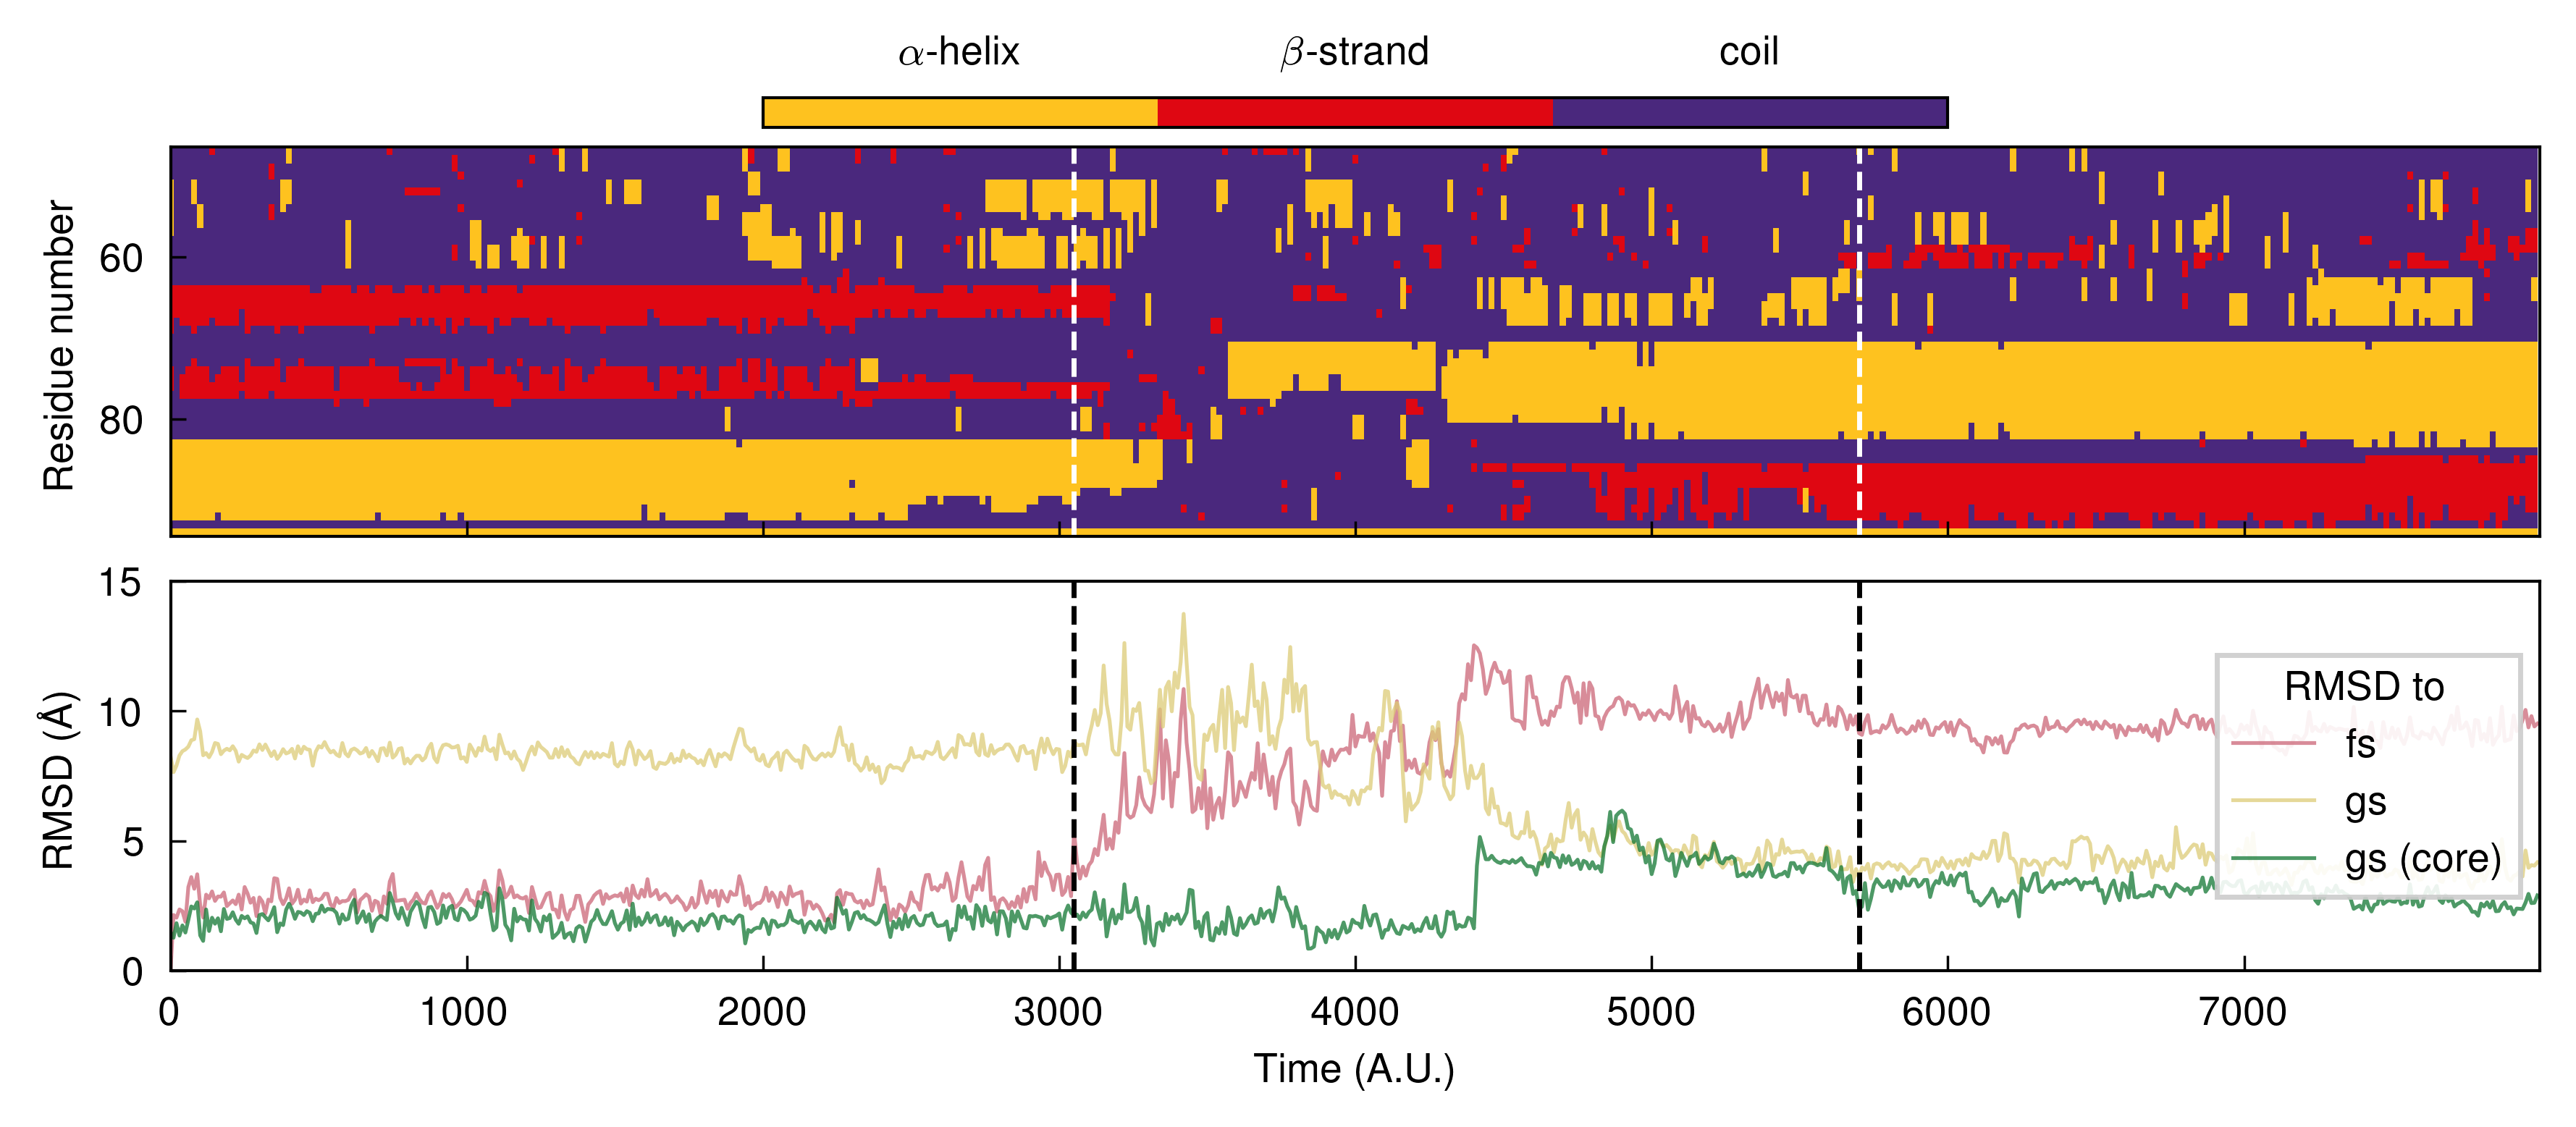

In [32]:
fig, (ax0, ax1) = plt.subplots(nrows=2, figsize=(7, 3), dpi=500, sharex=True, constrained_layout=True)

cmap = mpl.cm.get_cmap("paula", 3)
s, e, skip = 0, 8000, 20
transition_start, transition_end = 3050, 5700

x = np.arange(s, e, skip)
y = np.arange(47, 95)
im = ax0.pcolormesh(x, y, dssp[s:e:skip, 46:].T, cmap=cmap, vmin=-0.5, vmax=2.5)
ax0.axvline(transition_start, color="w", ls="--", lw=1.0)
ax0.axvline(transition_end, color="w", ls="--", lw=1.0)
ax0.invert_yaxis()
# ax0.set_xlabel("Time (A.U.)")
ax0.set_ylabel("Residue number")
# cb = pplt.colorbar(im, position="top", pad="5%", fraction=0.1)
cb = plt.colorbar(im, ax=ax0, location="top", pad=0.05, shrink=0.5, aspect=40)
cb.set_ticks(np.arange(3), labels=simple_labels, ha="center", rotation=0)
cb.ax.tick_params(length=0)

i = 13
skip = 10
t = np.arange(s, e, skip)
ax1.plot(t, rmsds_fs[i][s:e:skip] * 10, "C0", alpha=0.75, label="fs")
ax1.plot(t, rmsds_gs[i][s:e:skip] * 10, "C2", alpha=0.75, label="gs")
ax1.plot(t, rmsds_gs_core[i][s:e:skip] * 10, "C3", alpha=0.75, label="gs (core)")
ax1.axvline(transition_start, color="k", ls="--", lw=1.0)
ax1.axvline(transition_end, color="k", ls="--", lw=1.0)
ax1.set_xlabel("Time (A.U.)")
ax1.set_ylabel("RMSD (Å)")
ax1.set_xlim([s, e - 1])
ax1.set_ylim([0, 15])
ax1.label_outer()
ax1.legend(title="RMSD to", frameon=True, loc='right', framealpha=0.9, fancybox=False)
plt.savefig("../../fixed_p_runs/figures/dssp_fs2gs_run0_13.png", bbox_inches='tight')

# fs->gs, run_0, runs #13

In [19]:
i = 13
traj = mu.load_upside_traj(f"/project/dinner/scguo/kaiB/fixed_p_runs/trans_fs/run_0/fs_d91r.run.{i:02}.up")

dssp = md.compute_dssp(traj, simplified=True)
dssp = convert_to_array(dssp, simplified=True)

/scratch/local/jobs/10917107/ipykernel_442679/3467265689.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap("paula", 3)


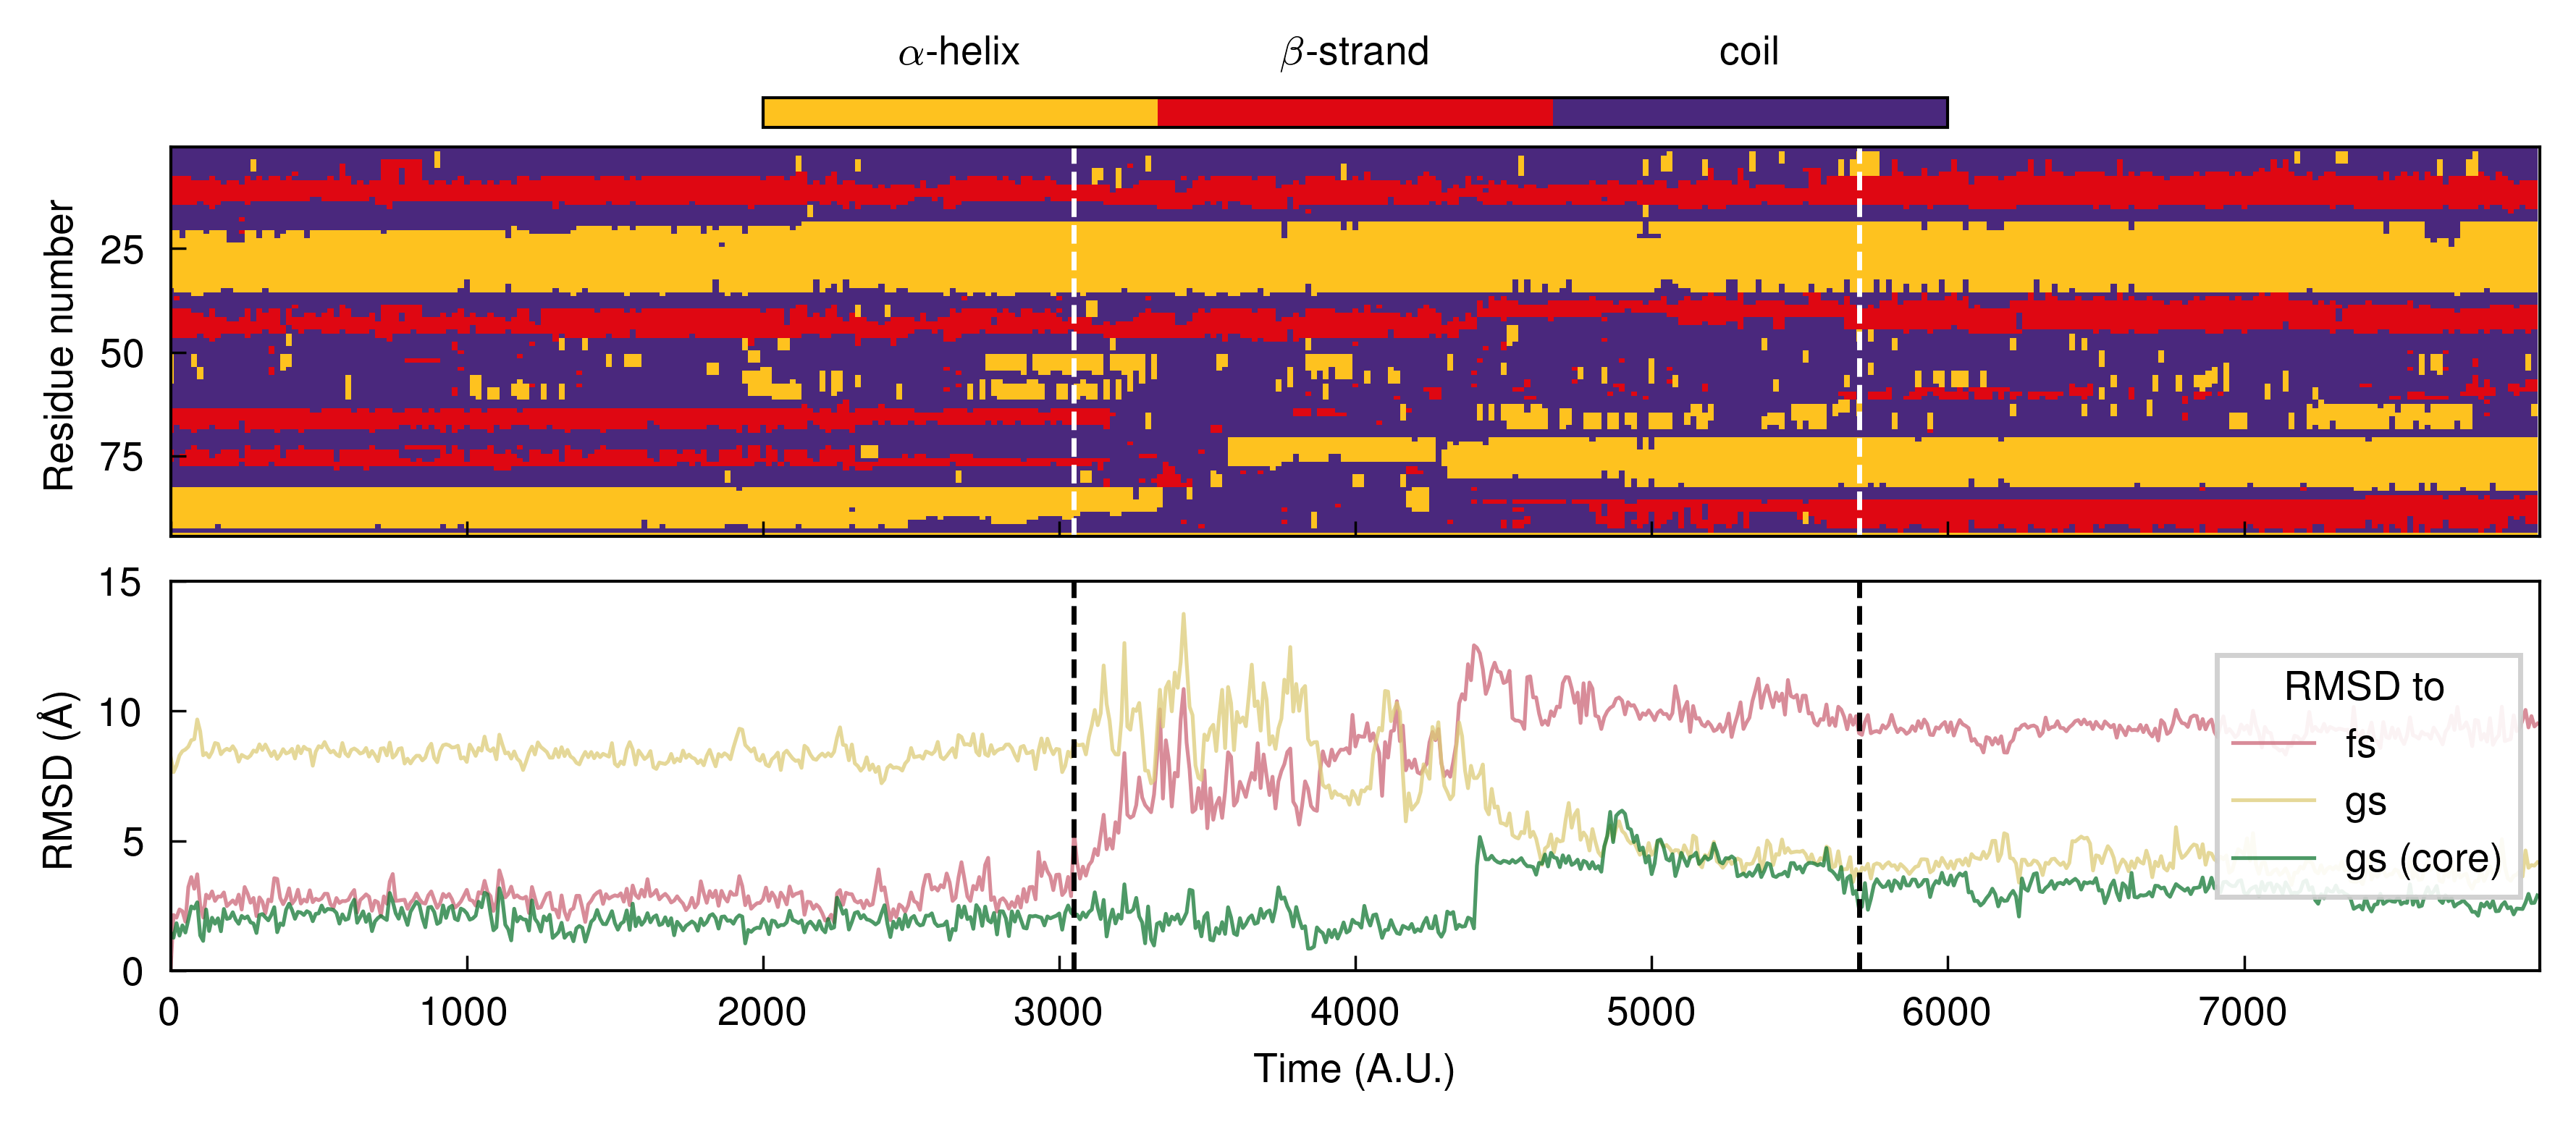

In [21]:
start, end = 0, 8000
transition = [3050, 5700]
fig, (ax0, ax1) = plot_dssp(
    dssp, rmsds_fs, rmsds_gs, rmsds_gs_core, start, end, i, skip1=20, skip2=10, transition=transition, loc='right', framealpha=0.9, fancybox=False
)
fig.savefig("../../fixed_p_runs/figures/dssp_fs2gs_run0_13.png", bbox_inches='tight')

# fs->gs, run_1, runs #2 and #20

In [22]:
rmsds_fs_1 = np.load(
    "/project/dinner/scguo/kaiB/fixed_p_runs/trans_fs/outputs/trans_fs_run_1_f_rmsds.pkl", allow_pickle=True
)
rmsds_gs_1 = np.load(
    "/project/dinner/scguo/kaiB/fixed_p_runs/trans_fs/outputs/trans_fs_run_1_p_rmsds.pkl", allow_pickle=True
)
rmsds_gs_core_1 = np.load(
    "/project/dinner/scguo/kaiB/fixed_p_runs/trans_fs/outputs/trans_fs_run_1_r_rmsds.pkl", allow_pickle=True
)

## Run 2

In [23]:
i = 2
traj = mu.load_upside_traj(f"/project/dinner/scguo/kaiB/fixed_p_runs/trans_fs/run_1/fs_d91r.run.{i:02}.up")

dssp = md.compute_dssp(traj, simplified=True)
dssp = convert_to_array(dssp, simplified=True)

/scratch/local/jobs/10917107/ipykernel_442679/3467265689.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap("paula", 3)


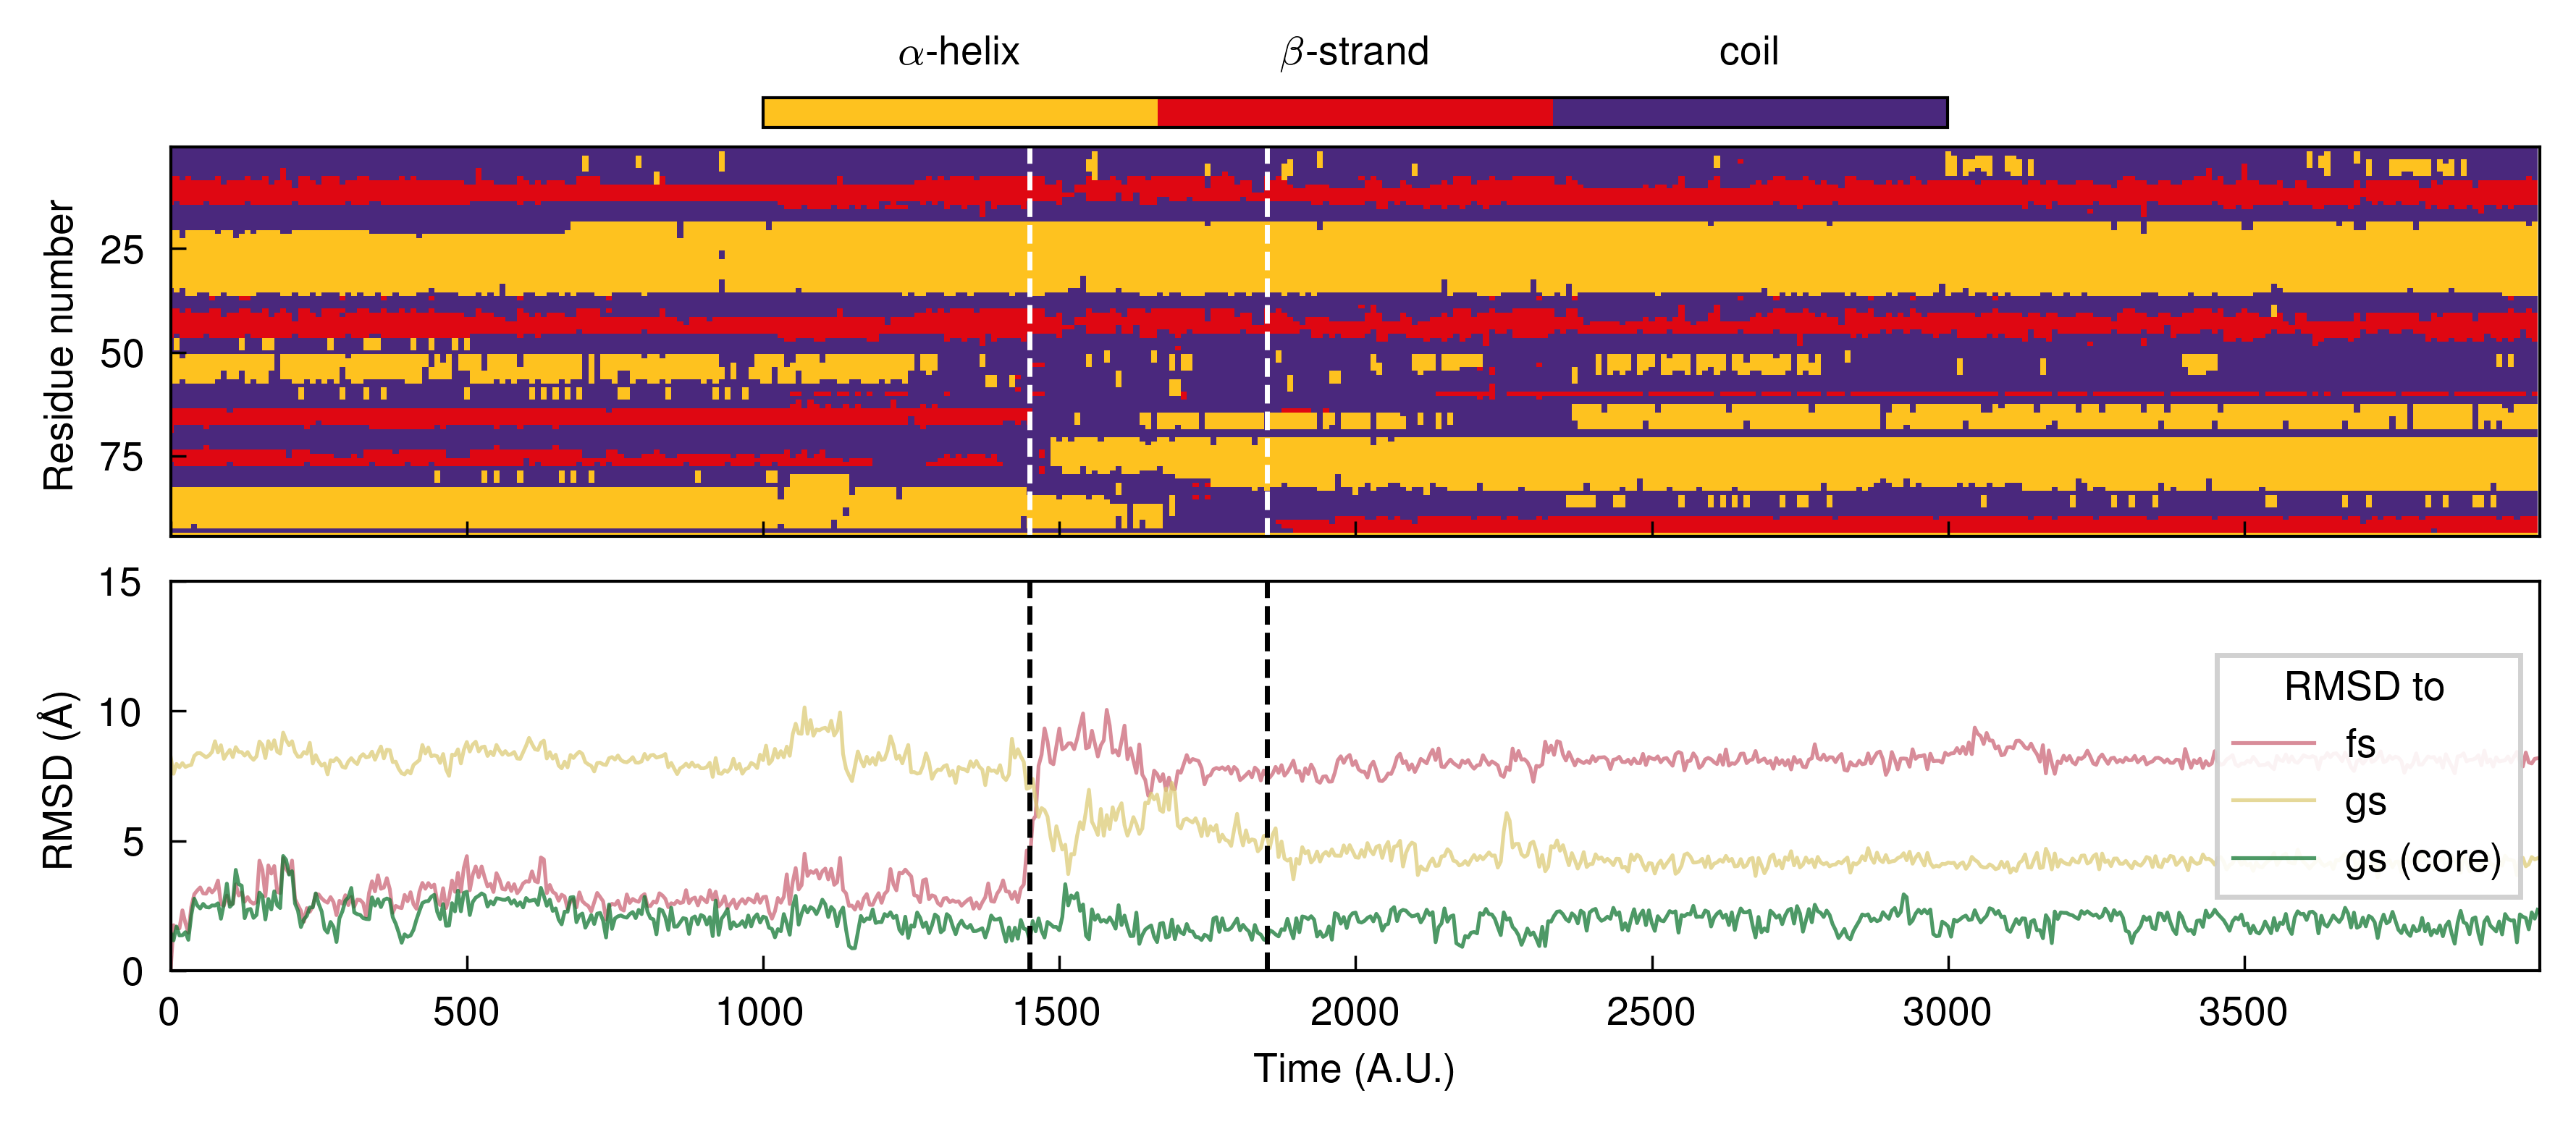

In [24]:
start, end = 0, 4000
transition = [1450, 1850]
fig, (ax0, ax1) = plot_dssp(
    dssp, rmsds_fs_1, rmsds_gs_1, rmsds_gs_core_1, start, end, i, skip1=10, skip2=5, transition=transition, loc='right', framealpha=0.9, fancybox=False
)
fig.savefig("../../fixed_p_runs/figures/dssp_fs2gs_run1_02.png", bbox_inches='tight')

## Run 20

In [25]:
i = 20
traj = mu.load_upside_traj(f"/project/dinner/scguo/kaiB/fixed_p_runs/trans_fs/run_1/fs_d91r.run.{i:02}.up")

dssp = md.compute_dssp(traj, simplified=True)
dssp = convert_to_array(dssp, simplified=True)

/scratch/local/jobs/10917107/ipykernel_442679/3467265689.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap("paula", 3)


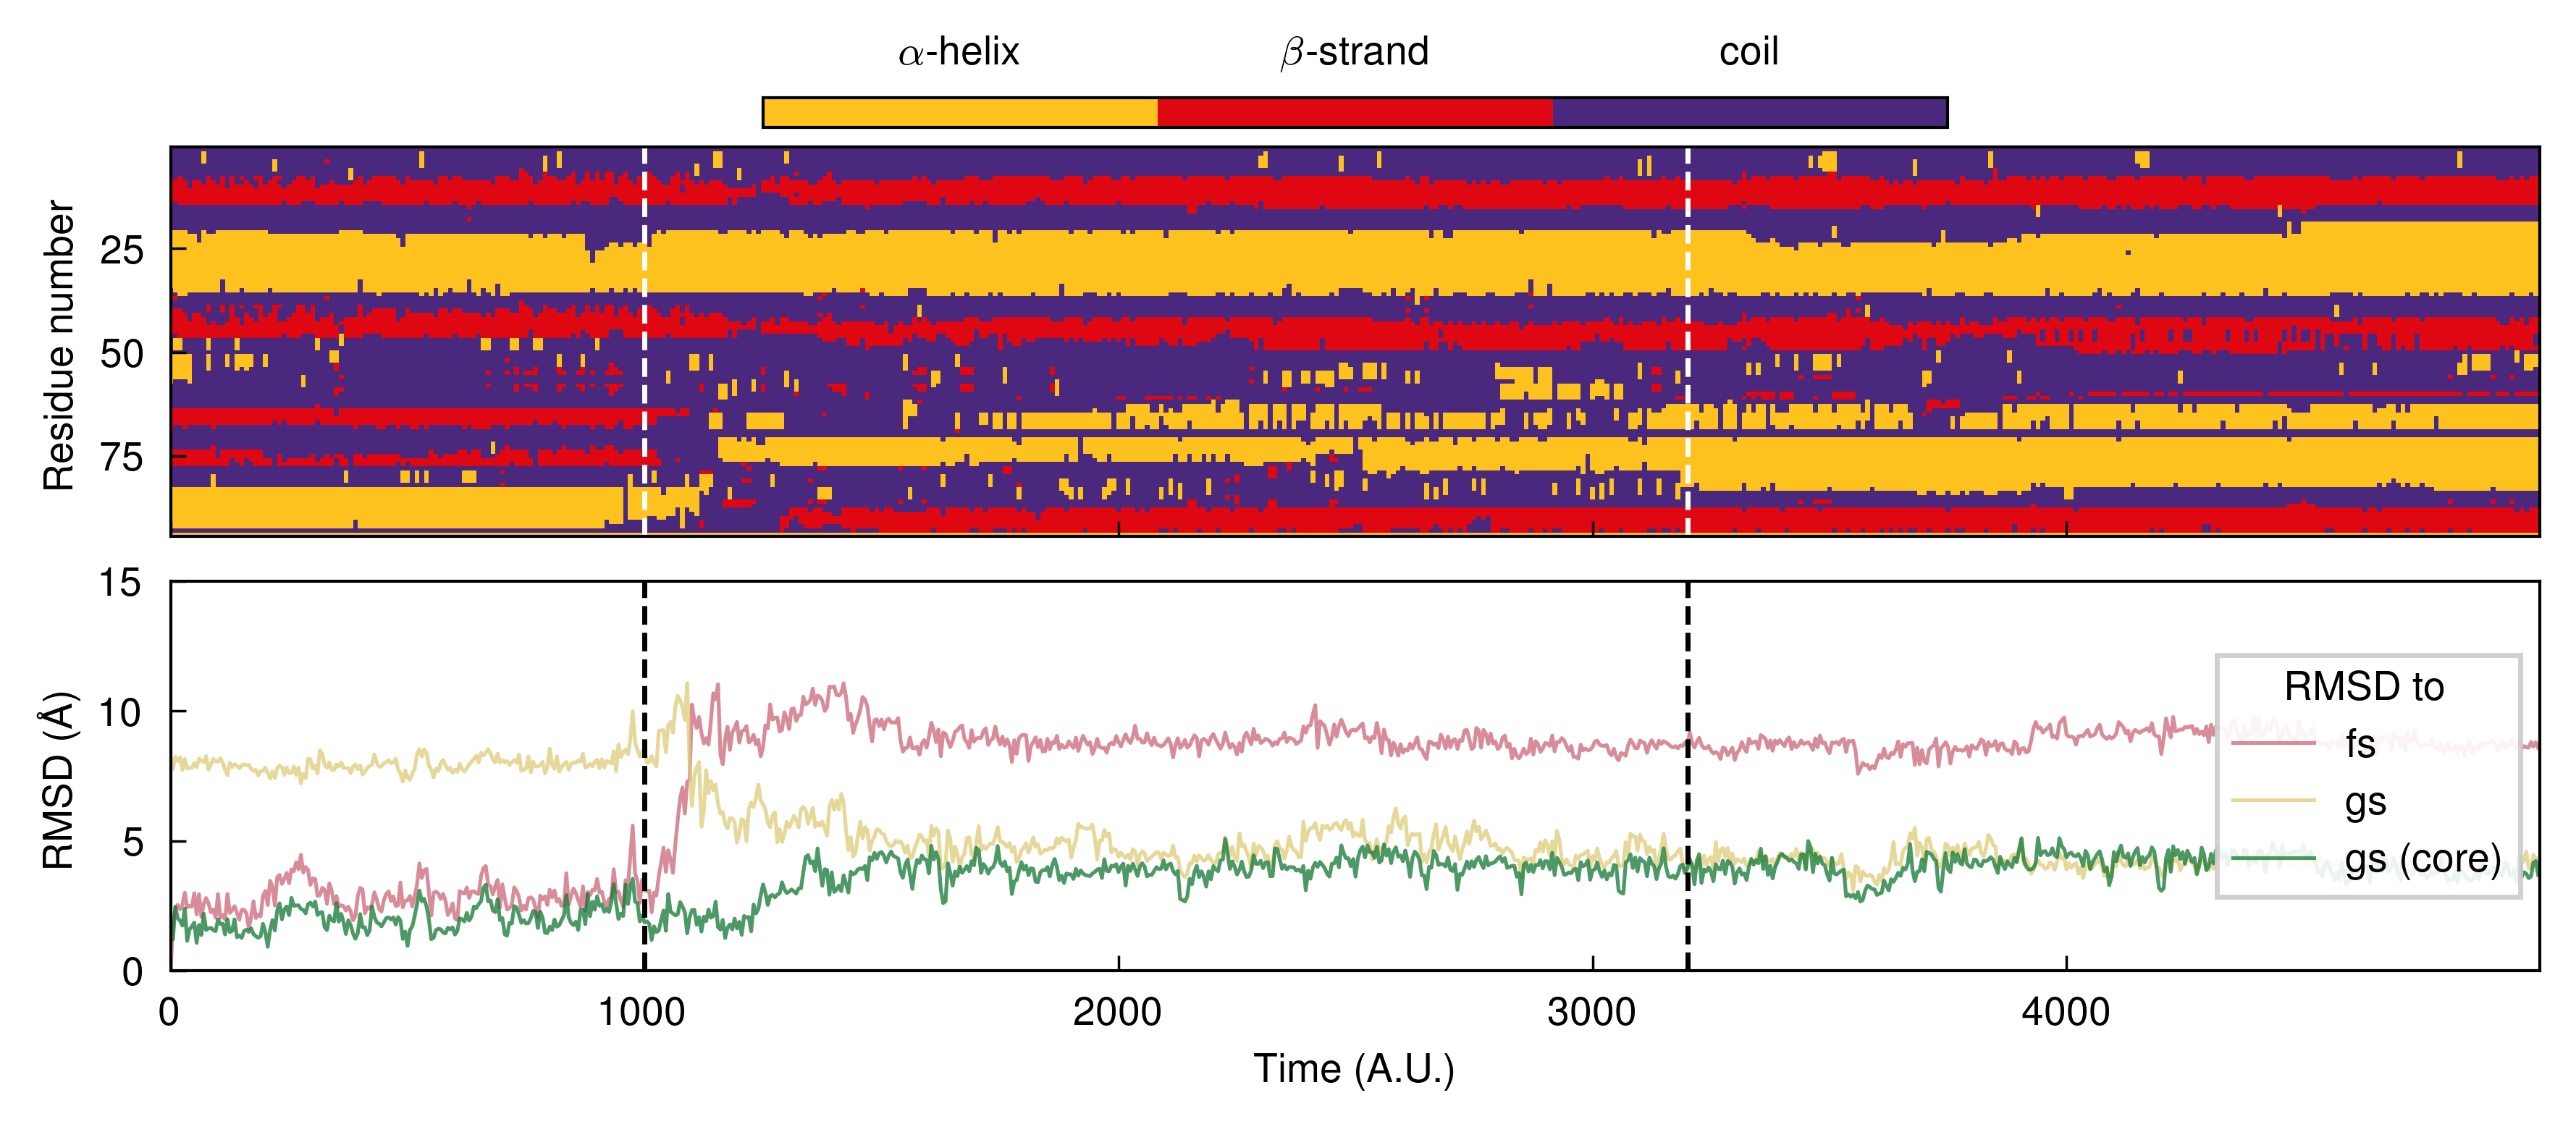

In [26]:
start, end = 0, 5000
transition = [1000, 3200]
fig, (ax0, ax1) = plot_dssp(
    dssp, rmsds_fs_1, rmsds_gs_1, rmsds_gs_core_1, start, end, i, skip1=10, skip2=5, transition=transition, loc='right', framealpha=0.9, fancybox=False
)
fig.savefig("../../fixed_p_runs/figures/dssp_fs2gs_run1_20.png", bbox_inches='tight')

# Run 02 #18

In [27]:
rmsds_fs_2 = np.load(
    "/project/dinner/scguo/kaiB/fixed_p_runs/trans_fs/outputs/trans_fs_run_2_f_rmsds.pkl", allow_pickle=True
)
rmsds_gs_2 = np.load(
    "/project/dinner/scguo/kaiB/fixed_p_runs/trans_fs/outputs/trans_fs_run_2_p_rmsds.pkl", allow_pickle=True
)
rmsds_gs_core_2 = np.load(
    "/project/dinner/scguo/kaiB/fixed_p_runs/trans_fs/outputs/trans_fs_run_2_r_rmsds.pkl", allow_pickle=True
)

In [28]:
i = 18
traj = mu.load_upside_traj(f"/project/dinner/scguo/kaiB/fixed_p_runs/trans_fs/run_2/fs_d91r.run.{i:02}.up")

dssp = md.compute_dssp(traj, simplified=True)
dssp = convert_to_array(dssp, simplified=True)

/scratch/local/jobs/10917107/ipykernel_442679/3467265689.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap("paula", 3)


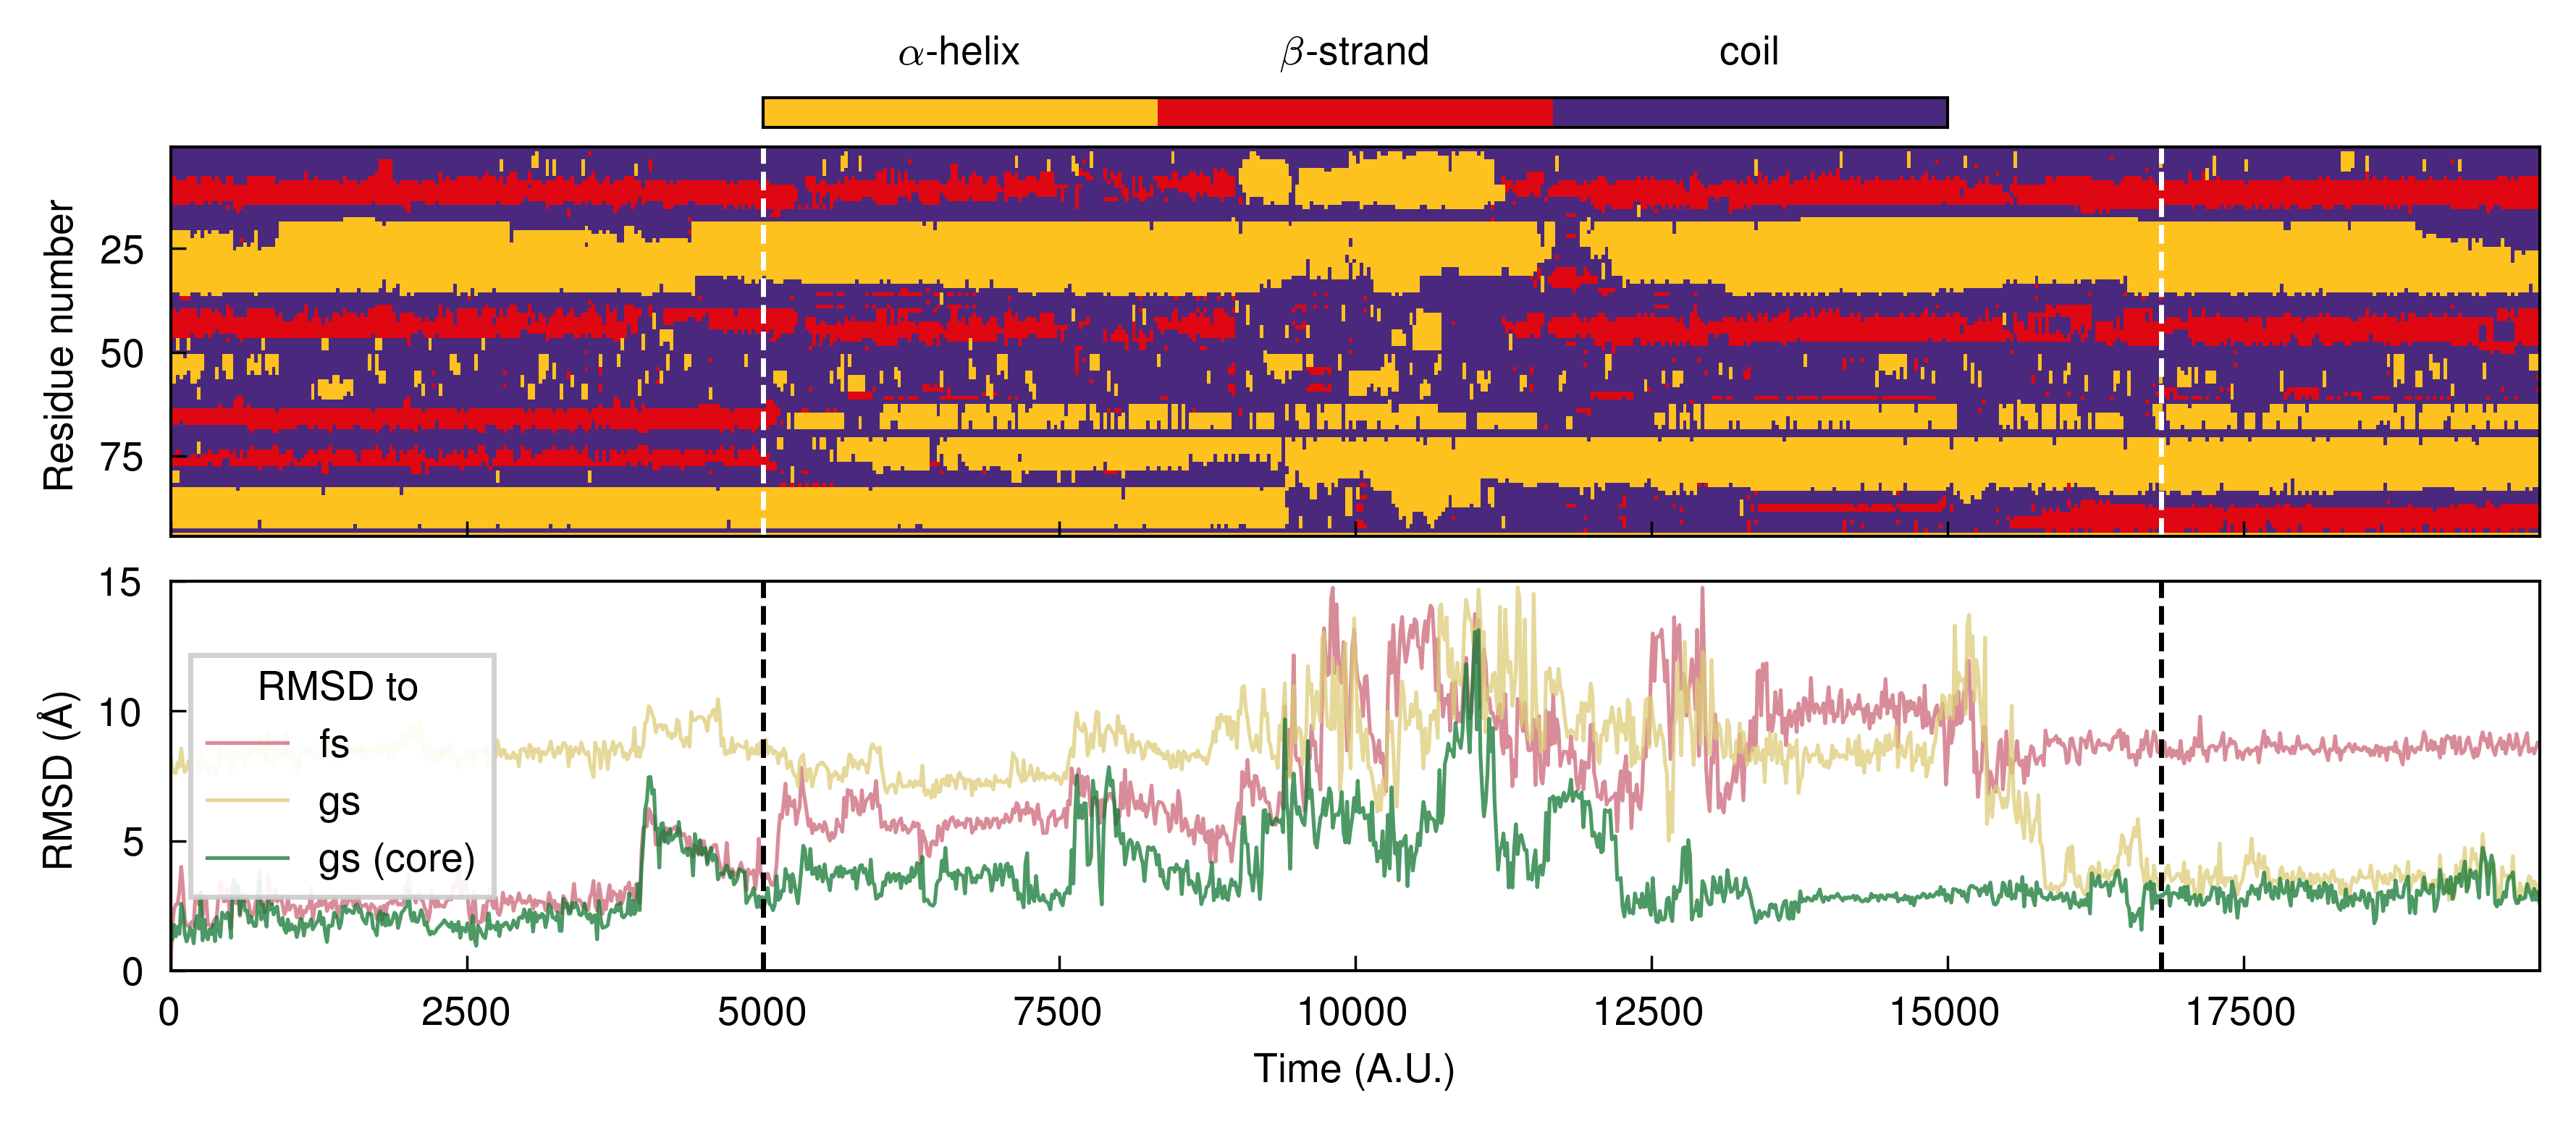

In [29]:
start, end = 0, 20000
transition = [5000, 16800]
fig, (ax0, ax1) = plot_dssp(
    dssp, rmsds_fs_2, rmsds_gs_2, rmsds_gs_core_2, start, end, i, skip1=30, skip2=15, transition=transition, loc='center left', framealpha=0.9, fancybox=False
)
fig.savefig("../../fixed_p_runs/figures/dssp_fs2gs_run2_18.png", bbox_inches='tight')